In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae
from pandas.tseries.offsets import BDay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5764866776671871675
 xla_global_id: -1]

In [3]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Financial/Gold_Price_Dataset.csv')
df_main.head()

,Name,US dollar,Euro,Japanese yen,Pound sterling,Canadian dollar,Swiss franc,Indian rupee,Chinese renmimbi,US dollar.1,...,Vietnamese dong,Egyptian pound,Korean won,Euro.1,Russian ruble,US dollar.2,South African rand,Chinese renmimbi.1,Canadian dollar.1,Australian dollar
0,29-12-1978,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,226.0,...,NaN,NaN,NaN,137.1,NaN,226.0,NaN,NaN,NaN,NaN
1,01-01-1979,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,226.0,...,NaN,NaN,NaN,137.1,NaN,226.0,NaN,NaN,NaN,NaN
2,02-01-1979,226.8,137.3,43164.9,111.5,263.7,359.6,1792.9,NaN,226.8,...,NaN,NaN,107470.0,137.3,NaN,226.8,194.6,NaN,263.7,193.6
3,03-01-1979,218.6,134.0,43717.9,108.0,264.4,365.9,1802.2,NaN,218.6,...,NaN,NaN,108027.4,134.0,NaN,218.6,192.2,NaN,264.4,193.0
4,04-01-1979,223.2,136.8,43674.9,110.7,264.1,366.4,1811.7,NaN,223.2,...,NaN,NaN,108602.5,136.8,NaN,223.2,193.0,NaN,264.1,194.6


In [ ]:
df_main.shape

(10901, 25)

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10901 entries, 0 to 10900
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                10901 non-null  object 
 1   US dollar           10901 non-null  float64
 2   Euro                10901 non-null  float64
 3   Japanese yen        10899 non-null  float64
 4   Pound sterling      10901 non-null  float64
 5   Canadian dollar     10899 non-null  float64
 6   Swiss franc         10899 non-null  float64
 7   Indian rupee        10899 non-null  float64
 8   Chinese renmimbi    9330 non-null   float64
 9   US dollar.1         10901 non-null  float64
 10  Turkish lira        9856 non-null   float64
 11  Saudi riyal         10899 non-null  float64
 12  Indonesian rupiah   10899 non-null  float64
 13  UAE dirham          10899 non-null  float64
 14  Thai baht           10899 non-null  float64
 15  Vietnamese dong     8050 non-null   float64
 16  Egyp

In [4]:
time = pd.date_range(start='12/29/1978',periods=10901,freq=BDay())
df_main['time_stamp'] = pd.DataFrame(time)
df_main.drop(['Name'],axis=1,inplace=True)
df_main = df_main.set_index('time_stamp')

In [5]:
df = df_main[['US dollar']]

In [6]:
df.shape

(10901, 1)

In [ ]:
df.isnull().sum()

US dollar    0
dtype: int64

In [7]:
df.columns=['USD']

In [8]:
df.head()

,USD
time_stamp,
1978-12-29,226.0
1979-01-01,226.0
1979-01-02,226.8
1979-01-03,218.6
1979-01-04,223.2


In [ ]:
df.tail()

,USD
time_stamp,
2020-10-05,1909.6
2020-10-06,1913.4
2020-10-07,1884.5
2020-10-08,1887.5
2020-10-09,1923.3


In [9]:
plt.rcParams['figure.figsize'] = [15,8]

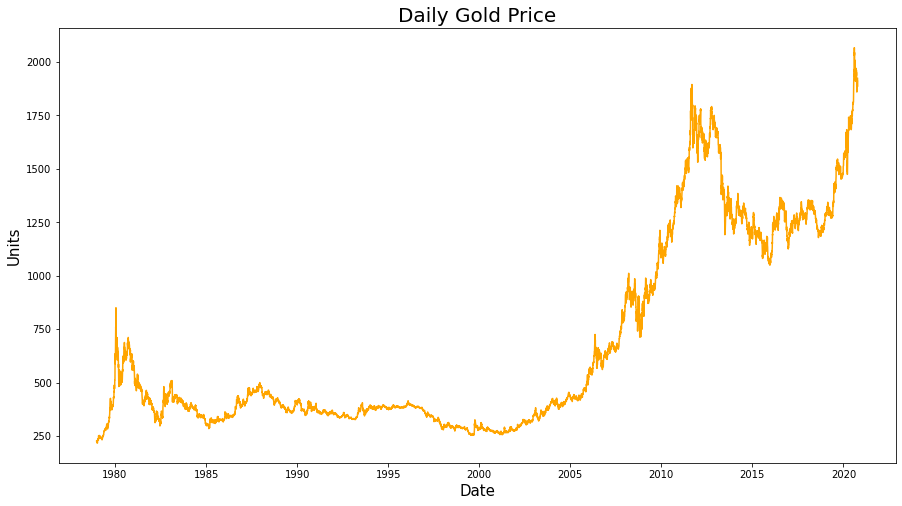

In [10]:
plt.plot(df,color='orange')
plt.title('Daily Gold Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [11]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [25]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['USD'] = df['USD'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [26]:
#Split data set into testing dataset and train dataset
train_size = 9801
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(9797, 1, 4)
(9797,)
(1096, 1, 4)
(1096,)


In [14]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.5 MB/s 


In [15]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('rnn_layer',min_value=8,max_value=256,step=8), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.3,0.4],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=8,max_value=256,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_3')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=32,
             validation_data=(testX, testY))

Trial 10 Complete [00h 08m 07s]
val_mape: 0.5916268825531006

Best val_mape So Far: 0.5724546909332275
Total elapsed time: 01h 00m 05s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_3
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 64
first_recurrent_dropout: 0.2
dense_layer: 72
Dropout_rate: 0.0
learning_rate: 0.001123741948168883
Score: 0.5724546909332275
Trial summary
Hyperparameters:
rnn_layer: 192
first_recurrent_dropout: 0.3
dense_layer: 144
Dropout_rate: 0.1
learning_rate: 0.0002610893532202307
Score: 0.5916268825531006
Trial summary
Hyperparameters:
rnn_layer: 88
first_recurrent_dropout: 0.3
dense_layer: 72
Dropout_rate: 0.1
learning_rate: 0.0012803204028293482
Score: 0.5926401019096375
Trial summary
Hyperparameters:
rnn_layer: 152
first_recurrent_dropout: 0.4
dense_layer: 152
Dropout_rate: 0.4
learning_rate: 0.0029717811720334567
Score: 0.5976554751396179
Trial summary
Hyperparameters:
rnn_layer: 64
first_recurrent_dropout: 0.2
dense_layer: 88
Dropout_rate: 0.2
learning_rate: 0.0073532321854386795
Score: 0.6026126146316528
Trial summary
Hyperparameters:


In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 72)                4680      
                                                                 
 dropout (Dropout)           (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                                 
Total params: 22,417
Trainable params: 22,417
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
model = Sequential()
model.add(LSTM(64,activation='relu',input_dim = 4,return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(LSTM(16,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.000011262424129007364)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 32, epochs = 400)

Epoch 1/400
307/307 [==============================] - 12s 12ms/step - loss: 98.8952 - mape: 98.8952 - val_loss: 99.2472 - val_mape: 99.2472
Epoch 2/400
307/307 [==============================] - 1s 5ms/step - loss: 96.5087 - mape: 96.5087 - val_loss: 98.3213 - val_mape: 98.3213
Epoch 3/400
307/307 [==============================] - 1s 5ms/step - loss: 93.6662 - mape: 93.6662 - val_loss: 97.3200 - val_mape: 97.3200
Epoch 4/400
307/307 [==============================] - 2s 5ms/step - loss: 90.7583 - mape: 90.7583 - val_loss: 96.2349 - val_mape: 96.2349
Epoch 5/400
307/307 [==============================] - 2s 5ms/step - loss: 87.7122 - mape: 87.7122 - val_loss: 95.0602 - val_mape: 95.0602
Epoch 6/400
307/307 [==============================] - 2s 5ms/step - loss: 84.5135 - mape: 84.5135 - val_loss: 93.7733 - val_mape: 93.7733
Epoch 7/400
307/307 [==============================] - 2s 5ms/step - loss: 81.1125 - mape: 81.1125 - val_loss: 92.3431 - val_mape: 92.3431
Epoch 8/400
307/307 [====

In [19]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [28]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.04 
Test MAPE : 0.79 


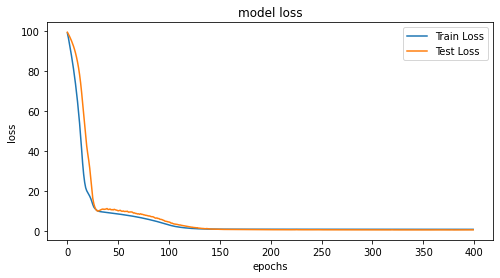

In [29]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [22]:
import seaborn as sns

In [23]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(9797,10893)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

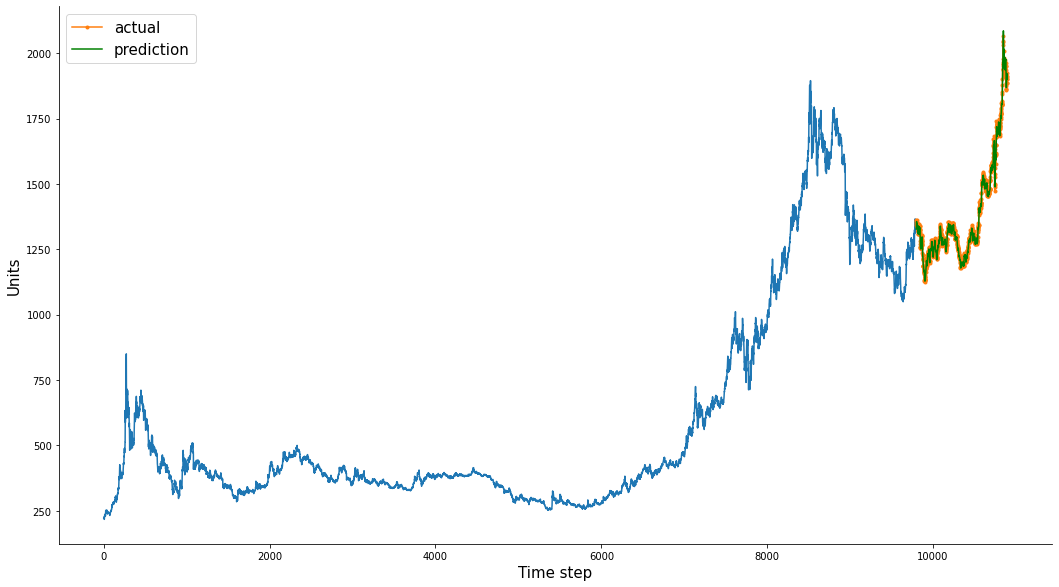

In [30]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)